In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import random
import itertools
from pprint import pprint
from copy import copy
from collections import Counter
from multiprocessing import Pool
from tqdm import tqdm
import time
from math import ceil

In [2]:
n_jobs = 8 # number of processes used during simulation

In [3]:
 matplotlib.set_loglevel("error") # suppress some warning

In [4]:
for directory in ['fig', 'res']:
    try:
        os.mkdir(directory)
    except:
        pass

In [5]:
blue = '#1f77b4'
red = '#d62728'
green = '#2ca02c'
cyan = '#17becf'
brown = '#8c564b'
yellow = '#ff7f0e'
grey = '#7f7f7f'

### 1.1 - Epidemic on a known graph

In [6]:
# function used to plot values against time
def time_plot(t, v, img, ylabel, xlabel='time', labels=None, colors=None, exclusions=[], x_tick_labels=None):
    # v is a 2d numpy array, every time series is on a row
    if len(v.shape) == 1:
        v = v[np.newaxis, ...] # add a dimension, this is more comfortable later
    fig = plt.figure(dpi=200, figsize=(9,3))
    ax = fig.add_subplot(111)
    ax.set_position([0.075,0.15,0.85,0.8])
    if labels is None:
        labels = ['']*v.shape[0]
        legend = False
    else:
        legend = True
    if colors is None:
        colors = [None]*v.shape[0] # for automatic color selection
    for i,(l,c) in enumerate(zip(labels, colors)):
        if l not in exclusions:
            ax.plot(np.array(t), v[i,:].T, label=l, color=c)
    if legend:
        ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if not x_tick_labels is None:
        xlabels = plt.xticks(ticks=np.array(t), labels=(x_tick_labels))
    plt.grid()
    plt.savefig(f'fig/{img}.eps', format='eps')
    return fig

In [7]:
# similar to previous function, used to make stackplots
def time_stackplot(t, v, img, ylabel, xlabel='time', labels=None, colors=None, x_tick_labels=None):
    fig = plt.figure(dpi=200, figsize=(9,3))
    ax = fig.add_subplot(111)
    ax.set_position([0.075,0.15,0.85,0.8])
    ax.stackplot(np.array(t), *[v[i,:].T for i in range(v.shape[0])], labels=labels, colors=colors)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if not x_tick_labels is None:
        xlabels = plt.xticks(ticks=np.array(t), labels=(x_tick_labels))
    plt.grid()
    plt.savefig(f'fig/{img}.eps', format='eps')
    return fig

In [8]:
S = 'S'
I = 'I'
R = 'R'
V = 'V'

In [9]:
# function used to simulate one SIR epidemic run
def simulate_SIR(adj_list, rho, beta, initial_state, vacc, n_steps=15):
    # adj_list is the adjacency list of the graph
    # number of nodes
    n = len(adj_list)
    # initial states of nodes
    state = initial_state
    # dictionary with counts of people that are in each state
    c = Counter(initial_state)
    # number of current vaccinated people
    v = 0
    # set of still non-vaccinated people
    novax = set(range(n))
    # number of newly infected, newly vaccinated, susceptible, infected, recovered and vaccinated people for each week
    evolution = [(c[I],vacc[0],c[S],c[I],c[R],v)]
    for w in range(n_steps):
        # compute the number of people that must be vaccinated in the current week:
        # vacc[w] is the percentage of population that must be vaccinated at the end of the week,
        # v is the number of vaccinated people at the beginning of the weed
        newvax = round(n*vacc[w]/100)-v
        for x in np.random.choice(list(novax), newvax, replace=False): # chose randomly non-vaccinated people
            novax.remove(x)
            c[state[x]] -= 1 # update count of people in a given state
            state[x] = V # update person state
        v += newvax # update count of vaccinated people
        new_infections = 0
        new_state = copy(state)
        for x in range(n): # for every person
            if state[x] == S: # if susceptible
                m = 0
                for y in adj_list[x]:
                    if state[y] == I:
                        m += 1
                # m is the number of infected neighbors of x
                if random.random() < 1 - (1-beta)**m: # with this probability, x becomes infected
                    # update counts if x becomes infected
                    new_state[x] = I
                    c[S] -= 1
                    c[I] += 1
                    new_infections += 1
            elif state[x] == I: # if x is infected (since earlier, not this week)
                if random.random() < rho: # with this probability x recovers
                    # update counts if x recovers
                    new_state[x] = R
                    c[I] -= 1
                    c[R] += 1
        state = new_state
        # append counts to the evolution list, values explained at the beginning of the function
        evolution.append((new_infections,newvax,c[S],c[I],c[R],v))
    return evolution

In [10]:
# function used to simulate and average multiple runs (n_sims) of SIR epidemics
# remake_graph indicates whether every run is made on a different graph
def sir_stats(graph_adjl, remake_graph=False, name='', rho=0.7, beta=0.3, vacc=[0], sim_time=15, n_sims=100, initial_infected=10, plot=True, new_plot=True, x_tick_labels=None):
    if remake_graph:
        # in this case graph_adjl is a function used to generate a graph's adjacency list
        g = graph_adjl
    else:
        # in this case graph_adjl is a graph's adjacency list
        g = lambda : graph_adjl
    vacc.extend([vacc[-1]]*(sim_time-len(vacc)))
    # vacc is a list with percentage of vaccinated people for each week,
    # extend it if it is shorter than the number of weeks, using the last given value
    # (no more vaccinated in the last weeks in this case)
    r = []
    for _ in range(n_sims):
        adj_list = g()
        n_nodes = len(adj_list)
        initial_state = [S]*n_nodes
        # initial infected nodes are randomly chosen, differently for each emidemic run
        for x in random.sample(range(n_nodes), initial_infected):
            initial_state[x] = I
        # save the result of each simulation in a list
        r.append(simulate_SIR(adj_list, rho, beta, initial_state, vacc, n_steps=sim_time))
    r = np.array(r)
    # average measures, separately for each week and each measure
    r = np.average(r, axis=0)
    if plot: # parameter specifying whether the function should make plots
        t = np.arange(r.shape[0])
        if x_tick_labels is None:
            x_tick_labels = t
        if max(vacc) == 0:
            # do not plot data on vaccinated people in this case
            if new_plot: # parameter specifying whether the function should also plot data on newly infected (and optionally newly vaccinated) people
                fig1 = time_plot(t, r[:,0].T, f'{name}new_infections', 'new infections', xlabel='time (week)', x_tick_labels=x_tick_labels, colors=[red])
            fig3 = time_stackplot(t, r[:,2:5].T, f'{name}categories', 'number of people in a given state', xlabel='time (week)', labels=['S','I','R'], x_tick_labels=x_tick_labels, colors=[blue, red, green])
        else:
            if new_plot:
                fig1 = time_plot(t, r[:,0:2].T, f'{name}new_infections', 'new infections and vaccinations', xlabel='time (week)', labels=['new infections', 'new vaccinations'], x_tick_labels=x_tick_labels, colors=[red, grey])
            fig3 = time_stackplot(t, r[:,2:].T, f'{name}categories', 'number of people in a given state', xlabel='time (week)', labels=['S','I','R','V'], x_tick_labels=x_tick_labels, colors=[blue, red, green, grey])
    return r[:,0].T

In [11]:
def adj_list_maker(G, indices=lambda x: x):
    adj_list = nx.adjacency_data(G)['adjacency']
    # create an adjacenty list for the graph, in the form of a list of lists
    # nodes are mapped to range(n_nodes) using the function indices
    adj_list = [[indices(u['id']) for u in l] for l in adj_list]
    return adj_list

In [12]:
def k_regular(n, k): # k is assumed to be even
    G = nx.Graph()
    # add edges between a node and the following (modular) k/2 nodes
    G.add_edges_from([(i,(j%n)+1) for i in range(1,n+1) for j in range(i, i+(k//2))])
    return G

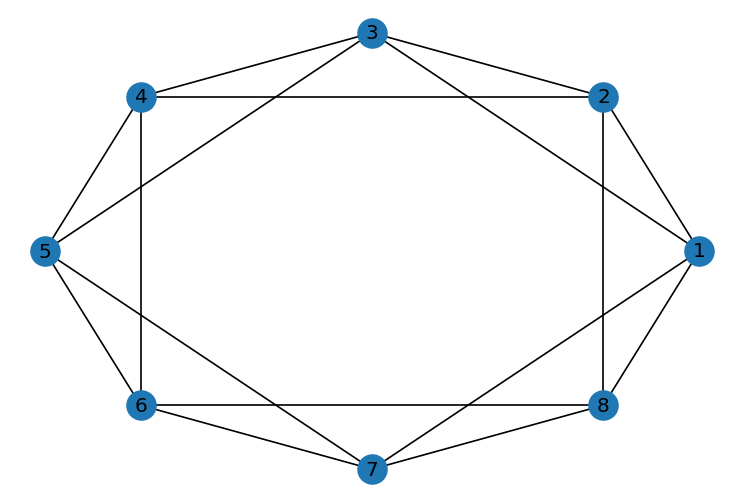

In [13]:
# example 4-regular graph with 8 nodes
G = k_regular(8,4)
plt.figure(dpi=120)
nx.draw_circular(G, with_labels=True)
plt.savefig('fig/regular_8_4.eps', format='eps')

array([10.  , 11.82, 10.79,  8.16,  5.8 ,  4.12,  3.02,  2.33,  1.63,
        1.22,  0.74,  0.55,  0.32,  0.29,  0.2 ,  0.15])

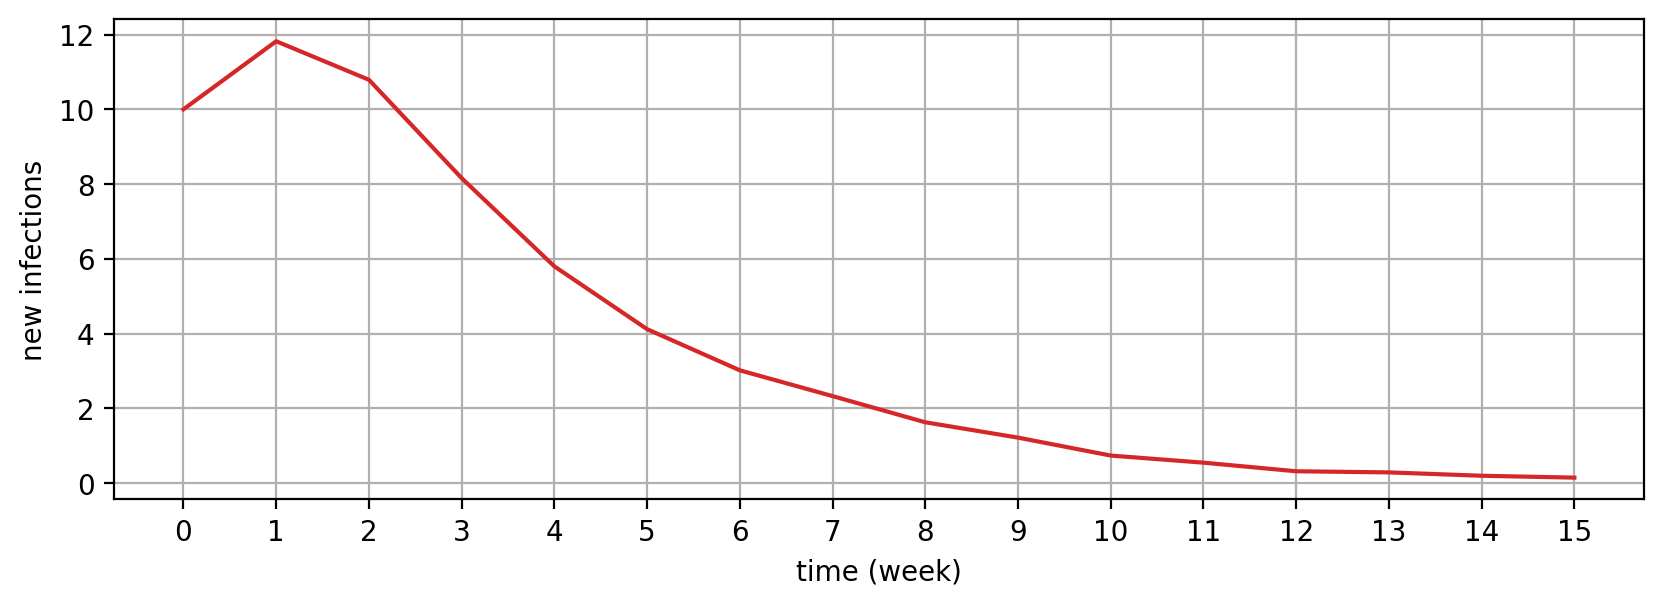

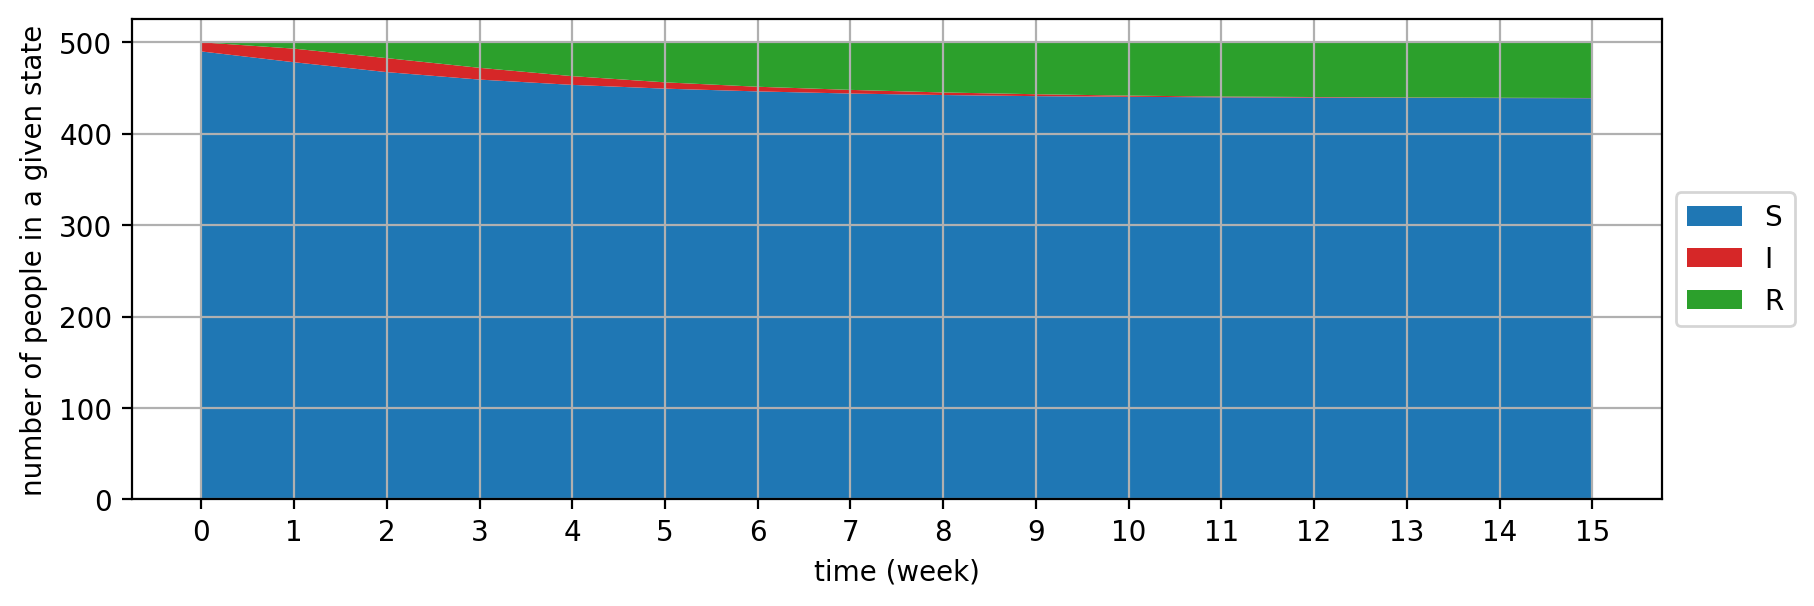

In [14]:
# simulate SIR epidemics on 4-regular graph with 500 nodes
N = 500
G11 = k_regular(N, 4)
indices = lambda x: x-1
G11_adj_list = adj_list_maker(G11, indices)
sir_stats(G11_adj_list, name='e1_1')

### 1.2 - Generate a random graph

In [15]:
def preferential_attachment_random_graph(n, k):
    G = nx.complete_graph(k+1)
    # every node has degree k
    degs = [k]*(k+1)
    # (approximate) number of edges that should be added for each inserted node
    c = k//2
    for i in range(k+1,n):
        t = np.array(degs)
        cc = c+(1&k&i) # add one more edge if k and i odd (once every two iterations if k is odd)
        # choose cc distinct nodes with probability proportional to their degrees
        for x in np.random.choice(i, cc, replace=False, p=t/t.sum()):
            G.add_edge(i, x)
            degs[x] += 1
        degs.append(cc)
    return G

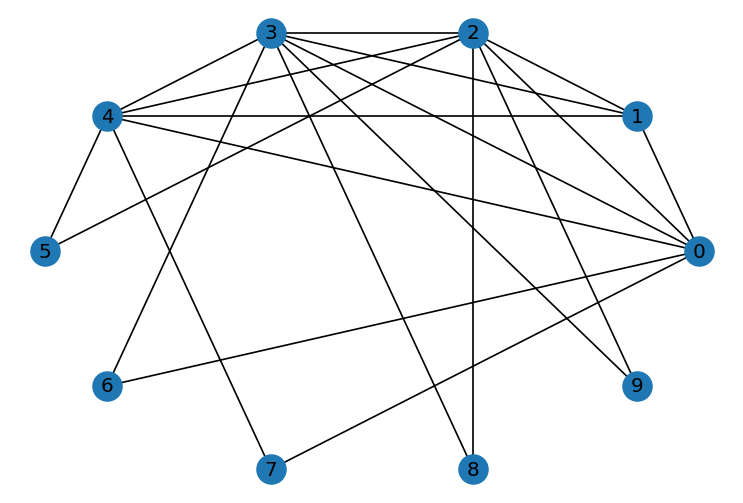

In [16]:
# example preferential attachment graph with 10 nodes and average degree 4
G12ex = preferential_attachment_random_graph(10,4)
plt.figure(dpi=120)
nx.draw_circular(G12ex, with_labels=True)
plt.savefig('fig/pa10_4.eps', format='eps')

In [17]:
# preferential attachment random graph with 900 nodes and average degree 10
G12 = preferential_attachment_random_graph(900, 10)

### 2 - Simulate a pandemic without vaccination

array([1.0000e+01, 1.7030e+01, 5.5080e+01, 1.0336e+02, 1.0324e+02,
       6.6530e+01, 3.1520e+01, 1.3580e+01, 5.4900e+00, 2.4600e+00,
       1.0500e+00, 3.3000e-01, 1.4000e-01, 8.0000e-02, 4.0000e-02,
       2.0000e-02])

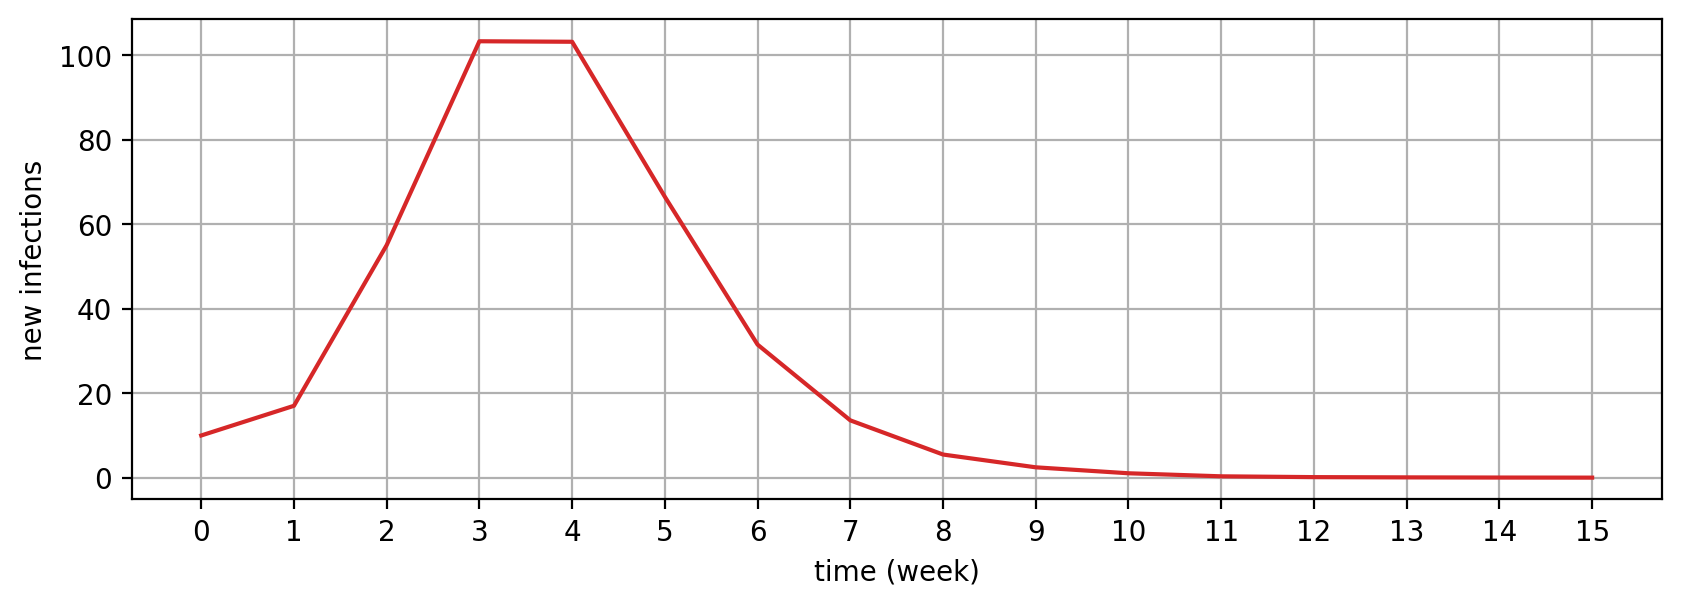

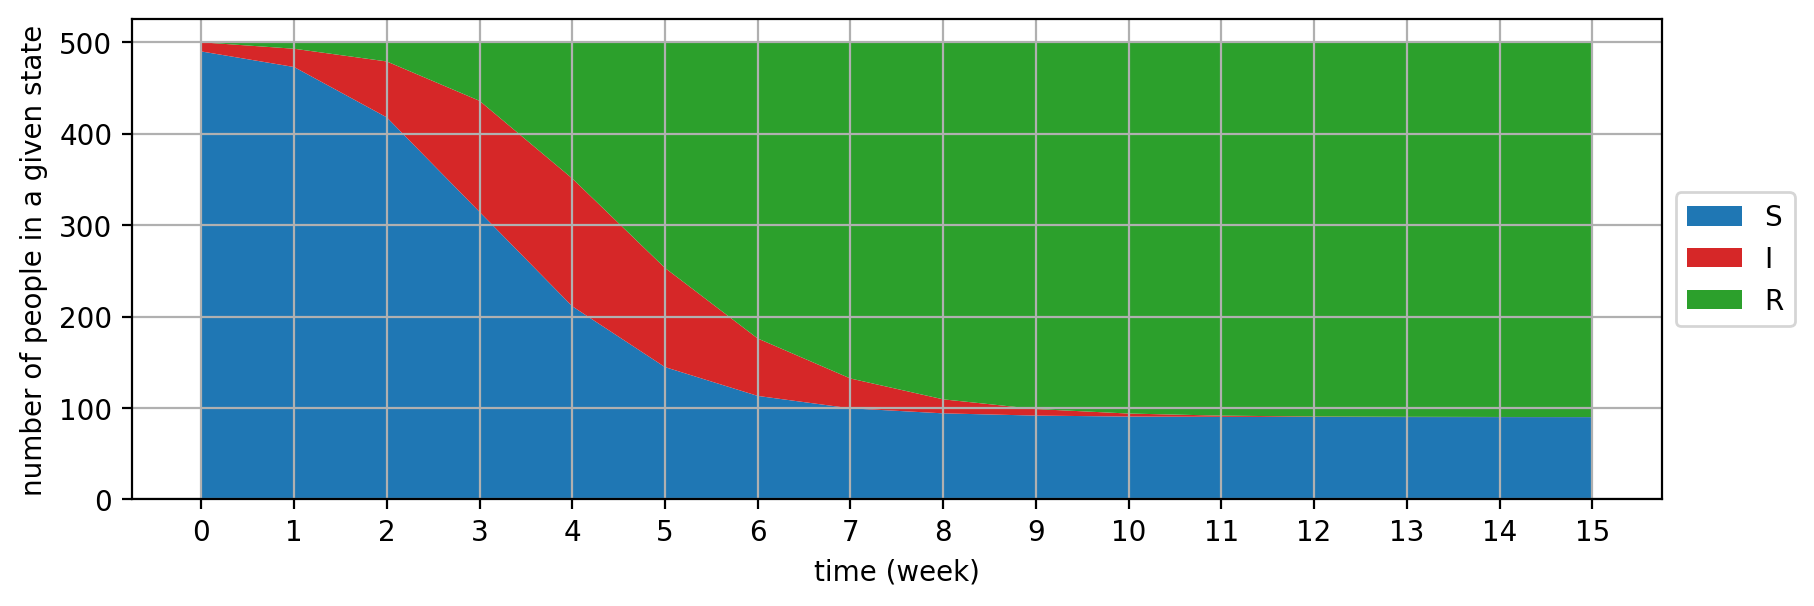

In [18]:
# using a preferential attachment random graph of 500 nodes and average degree 6
# use default parameters beta = 0.3 and rho = 0.7
# starting with 10 infected nodes and using 100 epidemic runs
# without vaccination
G2 = preferential_attachment_random_graph(500, 6)
sir_stats(adj_list_maker(G2), name='e2')

### 3 - Simulate a pandemic with vaccination

array([1.000e+01, 1.735e+01, 4.712e+01, 6.994e+01, 5.627e+01, 2.935e+01,
       1.129e+01, 3.820e+00, 1.290e+00, 5.200e-01, 3.200e-01, 1.900e-01,
       3.000e-02, 4.000e-02, 2.000e-02, 0.000e+00])

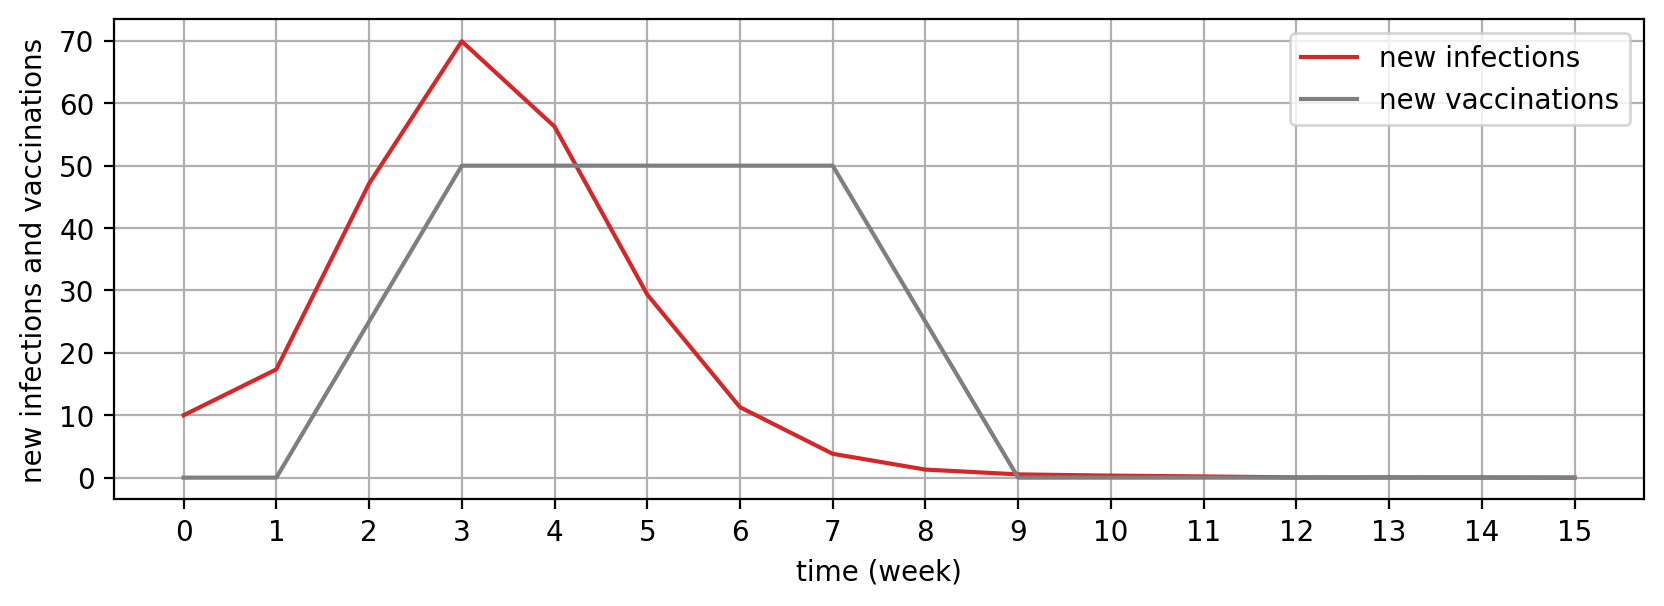

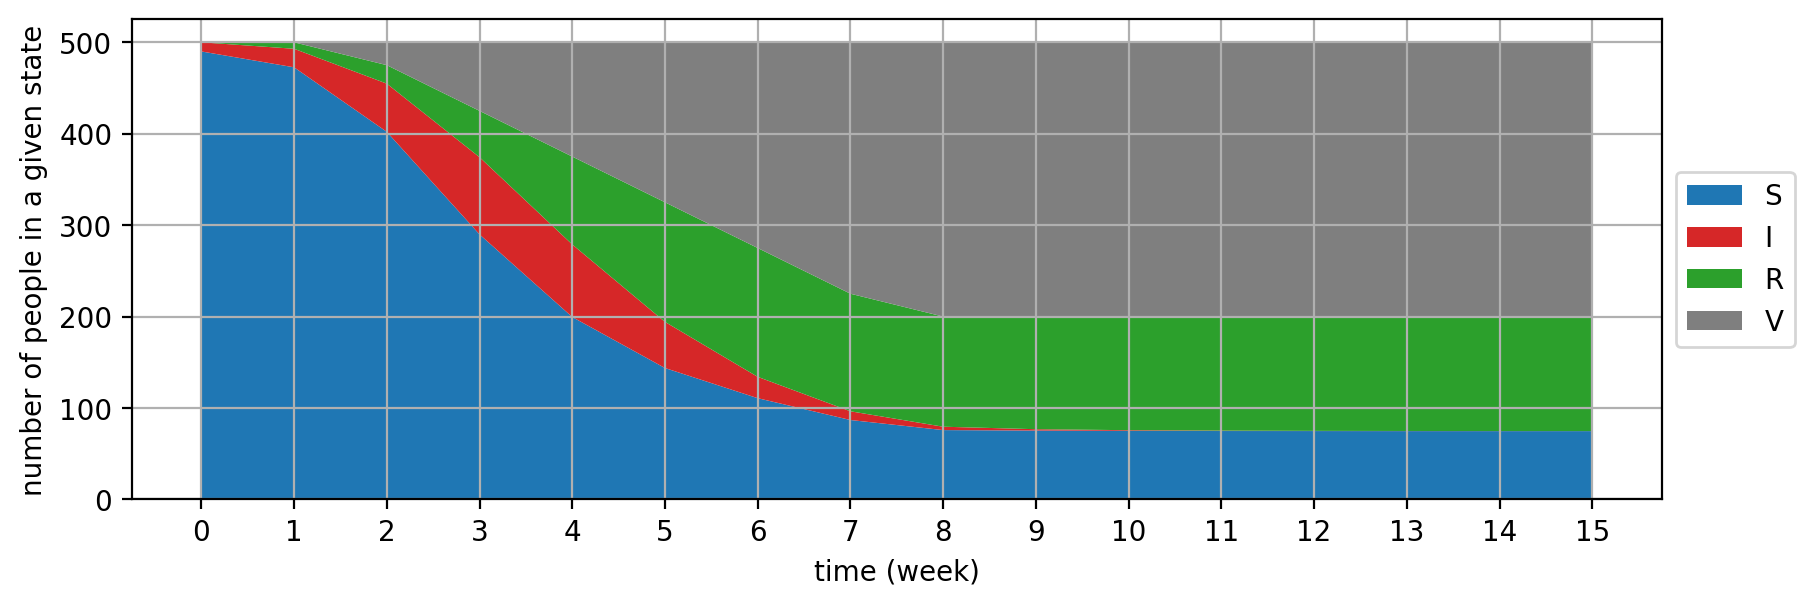

In [19]:
# same problem as in point 2, but with vaccination
G3 = preferential_attachment_random_graph(500, 6)
vacc = [0, 5, 15, 25, 35, 45, 55, 60]
sir_stats(adj_list_maker(G3), name='e3', vacc=vacc)

### 4 - The H1N1 pandemic in Sweden 2009

In [20]:
xlabels = (np.arange(16)+41)%52+1 # labels used in plots
I0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]) # actual (registered) infections

In [21]:
# function used to parallelize simulation of epidemics
def evaluate(args):
    (bounds, n_sims, initial_infected, vacc, graph_generator, remake_graph, p) = args
    bounds = np.array(bounds)
    ap = np.array(p)
    if any(ap < bounds[:,0]) or any(ap > bounds[:,1]):
        # in this case some parameter is out of bound
        return float('inf')
    # generate a graph with parameters p
    # G = graph_generator(p)
    if remake_graph:
        # in this case a function that generates a graph is provided
        graph = lambda : graph_generator(p)
    else:
        # in this case a graph is provided
        graph = graph_generator(p)
    # simulate epidemics on the generated graph with given parameters
    I1 = sir_stats(graph, remake_graph=remake_graph, rho=p[1], beta=p[0], vacc=vacc, n_sims=n_sims, initial_infected=initial_infected, plot=False)
    # return mean square error
    return np.square(I1-I0).mean()

In [22]:
# simulate
# start with only 1 infected node
initial_infected = 1
def simulate(p0, dp, bounds, dtypes, graph_generator, remake_graph=False, n_sims=10, initial_infected=initial_infected, dsteps=1):
    vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
    # dsteps is the number of different discretization levels for parameter deltas to use
    for st in range(dsteps):
        while True:
            # generate any combination of parameters, adding or subtracting (or none of them) deltas in any possible way
            p1s = list(itertools.product(*[(x-y,x,x+y) for x,y in zip(p0,dp)]))
            l = len(p1s)
            # create a process for each parameter setting
            with Pool(processes=n_jobs) as executor:
                mses = executor.map(evaluate, zip([bounds]*l, [n_sims]*l, [initial_infected]*l, [vacc]*l, [graph_generator]*l, [remake_graph]*l, p1s))
            # mses[i] contains the mean square error computed using parameters p1s[i]
            x = np.argmin(np.array(mses))
            p1 = p1s[x] # best parameters
            # if parameters did not change during the last run, decrease values of deltas
            if np.isclose(np.array(p0), np.array(p1)).all():
                break
            p0 = p1
        # decrease values of deltas, f indicates whether the new value has to be integer
        dp = [f(d/2) for d,f in zip(dp,dtypes)]
    return p1


In [23]:
def graph_generator(p):
    # return preferential_attachment_random_graph(934, p[2])
    return adj_list_maker(preferential_attachment_random_graph(934, p[2]))

In [24]:
# use specified parameters for H1N1 pandemic simulation
beta = 0.3
rho = 0.6
k = 10

d_beta = d_rho = 0.1
d_k = 1

p0 = (beta,rho,k) # initial parameters
dp = (d_beta, d_rho, d_k) # parameter deltas

p1 = simulate(p0, dp, [(0,1),(0,1),(1,float('inf'))], [float,float,int], graph_generator)

In [25]:
# save result parameters on files
for name,value,fmt in zip(['beta','rho','k'], p1, ["%.1f","%.1f","%d"]):
    with open(f'res/{name}1.txt','w') as outf:
        outf.write(f'{fmt}'%(value))

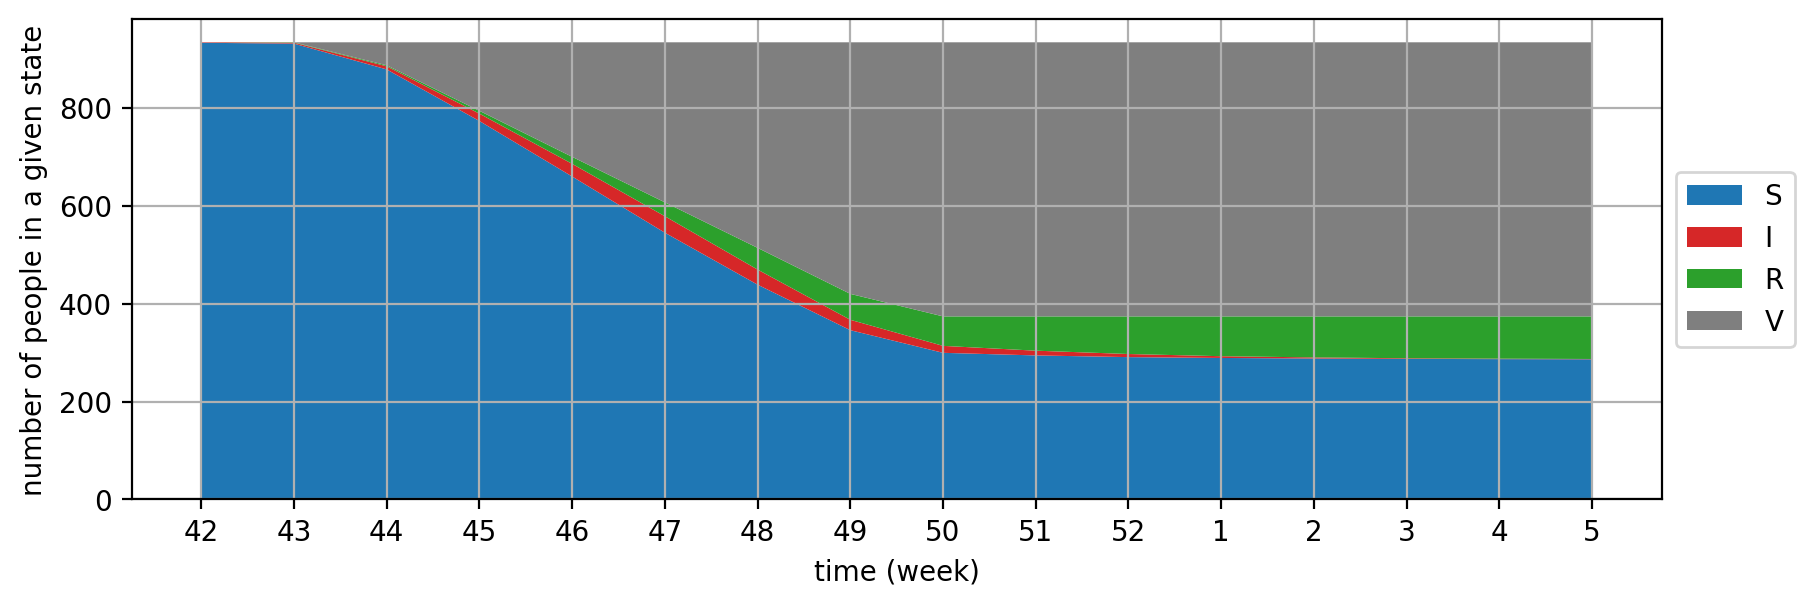

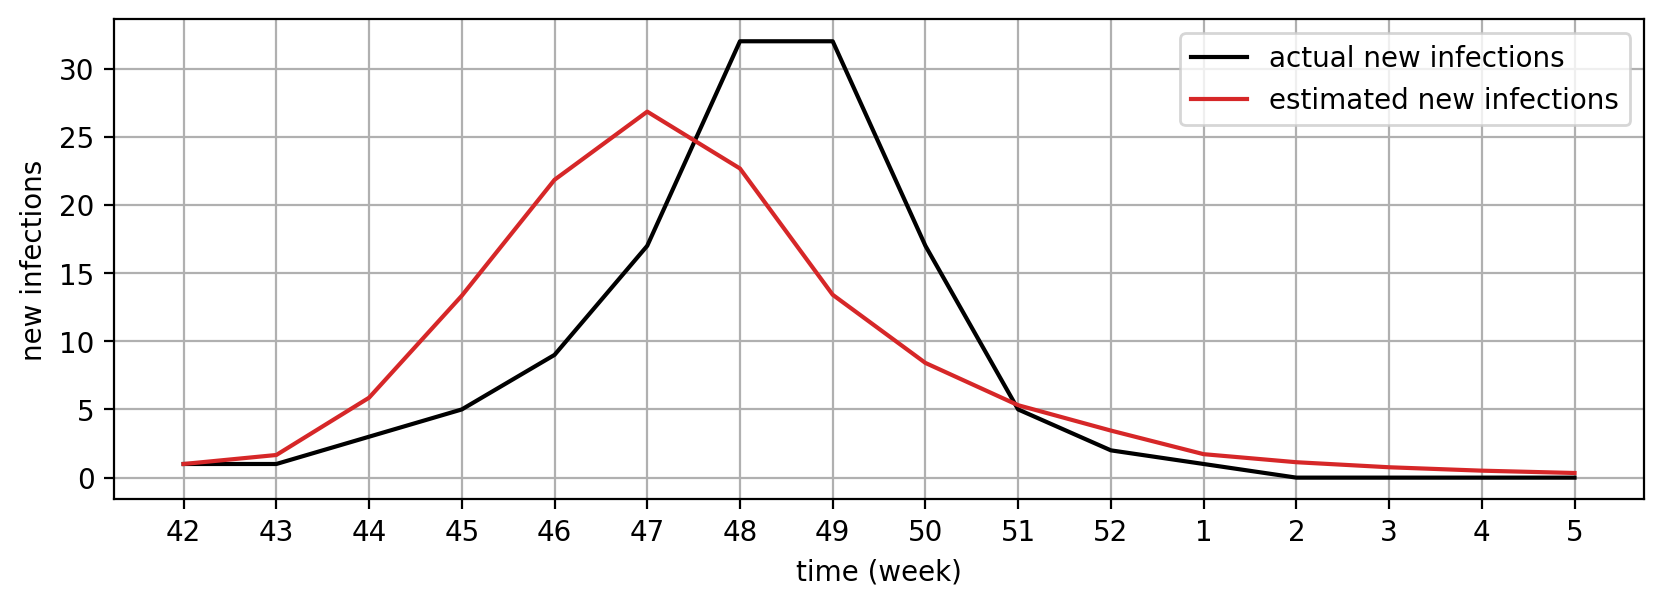

In [26]:
# simulate an epidemics with computed parameters
# G4 = preferential_attachment_random_graph(934, p1[2])
G4 = graph_generator(p1)
I1 = sir_stats(G4, name='e4', rho=p1[1], beta=p1[0], vacc=vacc, initial_infected=initial_infected, plot=True, new_plot=False, x_tick_labels=xlabels)
fig = time_plot(np.arange(I1.shape[0]), np.vstack((I0,I1)), 'e4-new_infections', 'new infections', xlabel='time (week)', labels=['actual new infections', 'estimated new infections'], x_tick_labels=xlabels, colors=['k', red])

In [27]:
rmse = np.sqrt(np.square(I1-I0).mean())
with open('res/rmse1.txt','w') as outf:
    outf.write(f'{rmse:.2f}')
print(rmse)

7.293979966383236


### 5 - Different graph approaches

In [28]:
# number of different deltas to use for each parameter,
# every step, each parameter delta is divided by 2 
dsteps = 2
# simulation intensity: any number is handled, but the first two models are slow anyway
sim_level = 2

In [29]:
# these functions will be used later to try to model Swedish population in different ways

def small_world(px): # generate small world random graph
    return adj_list_maker(nx.generators.random_graphs.newman_watts_strogatz_graph(934, px[2], px[3]))

def even_poisson(l, n):
    # generate n values distributed as a poisson with parameter lambda = l
    # they will be used as node degrees
    a = np.random.poisson(l, n)
    if a.sum()&1 == 1:
        # if the sum of all elements is odd,
        # increment the first element to make it even (sum of node degrees must be even)
        a[0] += 1
    return a

def configuration_model(px):
    return adj_list_maker(nx.generators.degree_seq.configuration_model(even_poisson(px[2], 934)))

def erdos_renyi(px):
    return adj_list_maker(nx.fast_gnp_random_graph(934, px[2]))

def preferential_attachment(px):
    return adj_list_maker(preferential_attachment_random_graph(934, px[2]))

In [30]:
# redefine simulation initial parameters (same as before)

beta = 0.3
rho = 0.6
k = 10

d_beta = d_rho = 0.1
d_k = 2

p0 = [beta, rho, k] # initial parameters
dp = [d_beta, d_rho, d_k] # parameter deltas
bounds = [(0,1), (0,1), (2,float('inf'))] # parameter bounds
transf = [float, float, ceil] # functions used to transform each delta after dividing it by 2 (k should remain integer)

In [31]:
params = {
    "Preferential attachment": [p0, dp, bounds, transf, preferential_attachment, 50],
        # the last parameter is a factor for the number of simulations
    "Small world": [p0+[0.002], dp+[0.001], bounds+[(0,0.1)], transf+[float], small_world, 5],
        # values added to the lists regard the probability of adding an edge between two far nodes
    "Erdős-Rényi": [p0[:2]+[0.01], dp[:2]+[0.002], bounds[:2]+[(0,0.05)], transf[:2]+[float], erdos_renyi, 50],
        # remove values regarind k and add the ones regarding p
    "Configuration model": [p0, dp, bounds, transf, configuration_model, 50]
}

In [32]:
res = [I0]
labels = ['actual new infections']
rmses = [0]
pres = []
# for method,par in list(params.items()):
for method,par in tqdm(list(params.items())):
    # compute best parameters
    p1 = simulate(*par[:-1], n_sims=ceil(par[-1]*sim_level), dsteps=dsteps, remake_graph=True)
    pres.append(p1) # save result
    G5_gen = lambda : par[4](p1) # function to generate graph
    I1 = sir_stats(G5_gen, remake_graph=True, n_sims=100, rho=p1[1], beta=p1[0], vacc=vacc, initial_infected=initial_infected, plot=False, new_plot=False, x_tick_labels=xlabels)
    # compute weekly infected people
    res.append(I1) # save result
    labels.append(method)
    rmses.append(np.sqrt(np.square(I1-I0).mean())) # compute RMSE

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [28:44<00:00, 431.01s/it]


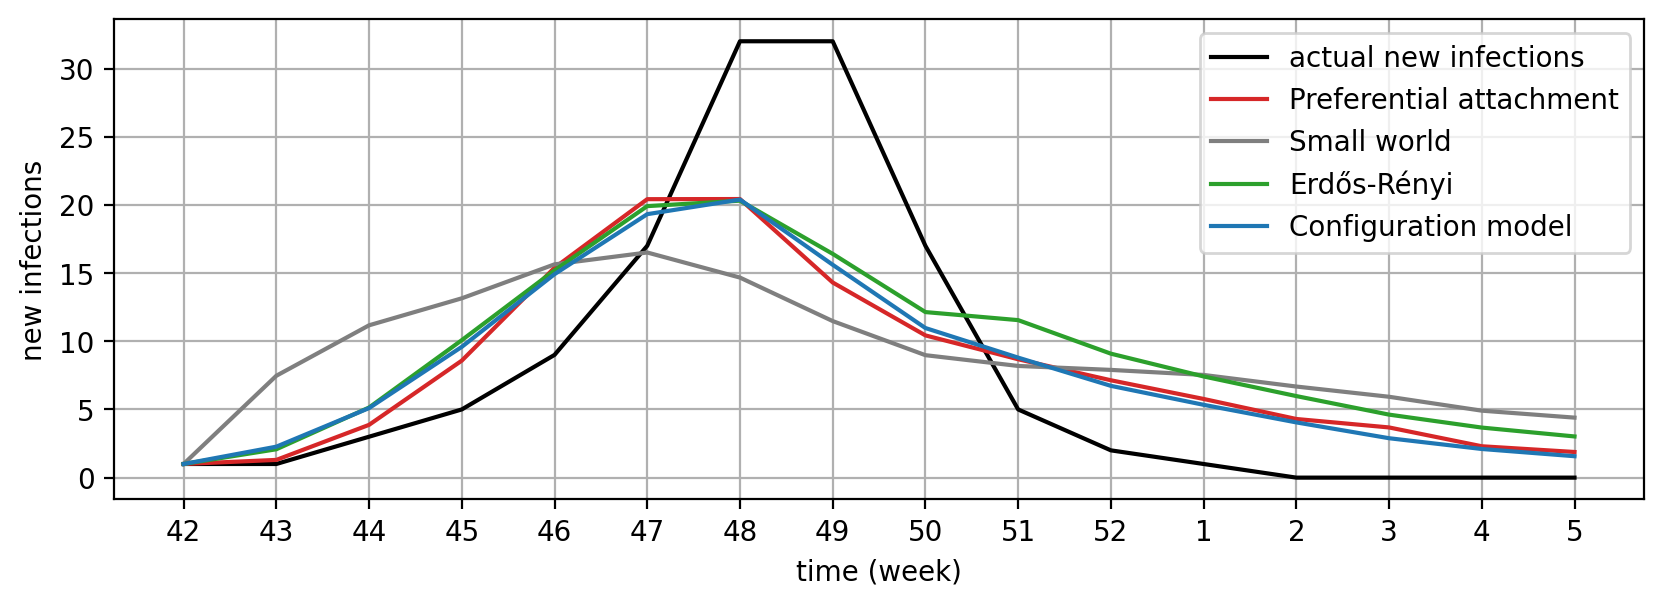

In [33]:
colors = ['k', red, grey, green, blue]
fig = time_plot(np.arange(I0.shape[0]), np.array(res), 'e5-new_infections', 'new infections', xlabel='time (week)', labels=labels, x_tick_labels=xlabels, colors=colors)

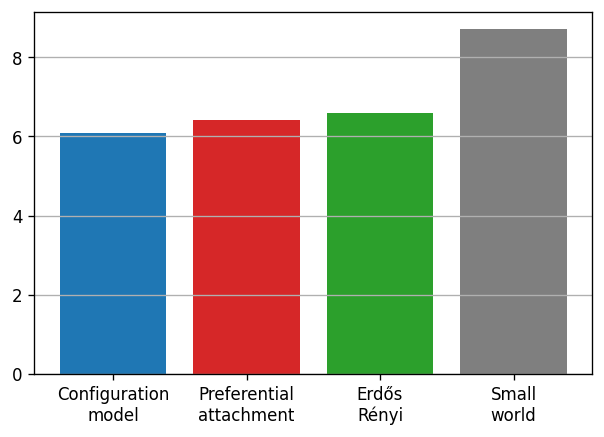

In [34]:
new_labels = [x.replace(' ','\n').replace('-','\n') for x in labels]
data = sorted(list(zip(new_labels, rmses, colors))[1:], key=lambda x: x[1])
data = list(zip(*data))
plt.figure(dpi=120)
plt.bar(data[0], data[1], color=data[2])
plt.grid(axis='y')
plt.savefig('fig/e5-rmses.eps', format='eps')

In [35]:
# write results to files, used for the report
fmt = {"rmse":"%.2f", "beta":"%.2f", "rho":"%.2f", "k":"%d", "p": "%.4f"}
for method,pset,rmse,pp in zip(params.keys(), [['k'],['k','p'],['p'],['k']], rmses[1:], pres):
    if method == "Erdős-Rényi":
        name = "erdos_renyi"
    else:
        name = method.replace(' ','_').lower()
    for pn,p in zip(['rmse','beta','rho']+pset, (rmse,)+pp):
        with open(f'res/{name}-{pn}.txt','w') as outf:
            outf.write(fmt[pn]%(p))